In [1]:
#import dependencies

import warnings 
warnings.filterwarnings('ignore')

#Basic packages
import os
import pandas as pd
import numpy as np
import datetime

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# statistics
from statsmodels.distributions.empirical_distribution import ECDF

# time series analysis
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Time Series
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

# prophet by Facebook
from fbprophet import Prophet

color = sns.color_palette()
sns.set_style('darkgrid')

In [2]:
train_data_csv = "train_data.csv"
test_data_csv = "test_data.csv"
sample_submission_csv = "test_predictions_format.csv"

In [12]:
train = pd.read_csv(train_data_csv, parse_dates = True,
                    low_memory = False, index_col = 'Date')
test = pd.read_csv(test_data_csv, parse_dates = True,
                   low_memory = False, index_col = 'Date')
submission = pd.read_csv(sample_submission_csv)

In [13]:
print("Check imported data")
print()
print("In total:")
print("train.shape {} ".format(train.shape))
print("test.shape {} ".format(test.shape))
print("submission.shape {} ".format(submission.shape))
print()
print("train.columns {} ".format(train.columns))
print("test.colmuns {} ".format(test.columns))
print("submission.colmuns {} ".format(submission.columns))
print()
print("train.index {} ".format(train.index))
print("test.index {} ".format(test.index))
print("submission.index {} ".format(submission.index))

Check imported data

In total:
train.shape (1017209, 9) 
test.shape (41088, 9) 
submission.shape (41088, 2) 

train.columns Index(['Store', 'DayOfWeek', 'Sales', 'ShopOpen', 'Promotion', 'StateHoliday',
       'SchoolHoliday', 'StoreType', 'AssortmentType'],
      dtype='object') 
test.colmuns Index(['Id', 'Store', 'DayOfWeek', 'ShopOpen', 'Promotion', 'StateHoliday',
       'SchoolHoliday', 'StoreType', 'AssortmentType'],
      dtype='object') 
submission.colmuns Index(['Id', 'Sales'], dtype='object') 

train.index DatetimeIndex(['2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31', '2015-07-31', '2015-07-31',
               '2015-07-31', '2015-07-31',
               ...
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01', '2013-01-01', '2013-01-01',
               '2013-01-01', '2013-01-01'],
              dtype='datetime64[ns]', name='Date', length=1017209, freq=None) 
test.inde

In [5]:
#train_df['date'] = pd.to_datetime(train_df['Date'], format="%Y-%m-%d")
train.head()

,Store,DayOfWeek,Sales,ShopOpen,Promotion,StateHoliday,SchoolHoliday,StoreType,AssortmentType
Date,,,,,,,,,
2015-07-31,1,5,5263,1,1,0,1,c,a
2015-07-31,2,5,6064,1,1,0,1,a,a
2015-07-31,3,5,8314,1,1,0,1,a,a
2015-07-31,4,5,13995,1,1,0,1,c,c
2015-07-31,5,5,4822,1,1,0,1,a,a


In [15]:
del train["StoreType"]
del train["AssortmentType"]
del test["StoreType"]
del test["AssortmentType"]

In [17]:
# rows which contains NA column
print(train[train.isna().any(axis=1)])

# rows which contains NA column
print(test[test.isna().any(axis=1)])

Empty DataFrame
Columns: [Store, DayOfWeek, Sales, ShopOpen, Promotion, StateHoliday, SchoolHoliday]
Index: []
Empty DataFrame
Columns: [Id, Store, DayOfWeek, ShopOpen, Promotion, StateHoliday, SchoolHoliday]
Index: []


In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1017209 entries, 2015-07-31 to 2013-01-01
Data columns (total 7 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Sales          1017209 non-null  int64 
 3   ShopOpen       1017209 non-null  int64 
 4   Promotion      1017209 non-null  int64 
 5   StateHoliday   1017209 non-null  object
 6   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(6), object(1)
memory usage: 62.1+ MB


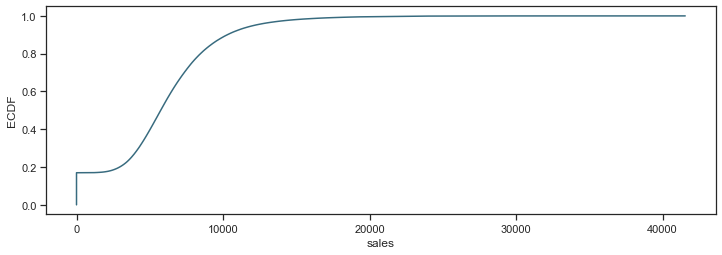

In [19]:
sns.set(style = "ticks")# to format into seaborn 
c = '#386B7F' # basic color for plots
plt.figure(figsize = (12, 13))

plt.subplot(313)
cdf = ECDF(train['Sales'])
plt.plot(cdf.x, cdf.y, label = "statmodels", color = c);
plt.xlabel('sales'); plt.ylabel('ECDF');

In [26]:
train_X = train.copy(deep=True)
del train_X['Sales']
train_y = train['Sales']

In [27]:
trainx = train.reset_index()
trainx.head()

,Date,Store,DayOfWeek,Sales,ShopOpen,Promotion,StateHoliday,SchoolHoliday
0,2015-07-31,1,5,5263,1,1,0,1
1,2015-07-31,2,5,6064,1,1,0,1
2,2015-07-31,3,5,8314,1,1,0,1
3,2015-07-31,4,5,13995,1,1,0,1
4,2015-07-31,5,5,4822,1,1,0,1


In [28]:
test_X = test.copy(deep=True)
del test_X['Id']
test_X.columns

Index(['Store', 'DayOfWeek', 'ShopOpen', 'Promotion', 'StateHoliday',
       'SchoolHoliday'],
      dtype='object')

In [29]:
testx = test.drop('Id',axis=1)
testx = testx.reset_index()
testx.head()

,Date,Store,DayOfWeek,ShopOpen,Promotion,StateHoliday,SchoolHoliday
0,2015-09-17,1,4,1,1,0,0
1,2015-09-17,3,4,1,1,0,0
2,2015-09-17,7,4,1,1,0,0
3,2015-09-17,8,4,1,1,0,0
4,2015-09-17,9,4,1,1,0,0


In [31]:
train_X['StateHoliday'].replace(to_replace=['a', 'b', 'c'], value=[1, 1, 1], inplace=True)

In [32]:
train_X['StateHoliday'].value_counts()

0    986159
1     31050
Name: StateHoliday, dtype: int64

In [33]:
test_X['StateHoliday'].replace(to_replace=['a'], value=[1], inplace=True)
test_X['StateHoliday'].value_counts()

0    40908
1      180
Name: StateHoliday, dtype: int64

In [35]:
from auto_ts import auto_timeseries

In [37]:
model = auto_timeseries(score_type='rmse',forecast_period=100,
                time_interval='D',
                non_seasonal_pdq=None, seasonality=False, seasonal_period=1,
                model_type=['ML'],
                verbose=2)

In [46]:
#train['StateHoliday'].replace(to_replace=['a', 'b', 'c'], value=[1, 1, 1], inplace=True)
train['ShopOpen'].value_counts()

1    844392
0    172817
Name: ShopOpen, dtype: int64

In [38]:
ts_column = 'Date'
target = 'Sales'

Start of Fit.....
Running Augmented Dickey-Fuller test with paramters:
    maxlag: 31 regression: c autolag: BIC
Results of Augmented Dickey-Fuller Test:
+-----------------------------+------------------------------+
|                             | Dickey-Fuller Augmented Test |
+-----------------------------+------------------------------+
|        Test Statistic       |      -33.12720931212863      |
|           p-value           |             0.0              |
|          #Lags Used         |             31.0             |
| Number of Observations Used |          1017177.0           |
|     Critical Value (1%)     |     -3.4303564288875017      |
|     Critical Value (5%)     |     -2.8615428414957895      |
|     Critical Value (10%)    |      -2.566771512423857      |
+-----------------------------+------------------------------+
 this series is stationary
    Target variable given as = Sales
Start of loading of data.....
Input is data frame. Performing Time Series Analysis
ts_col

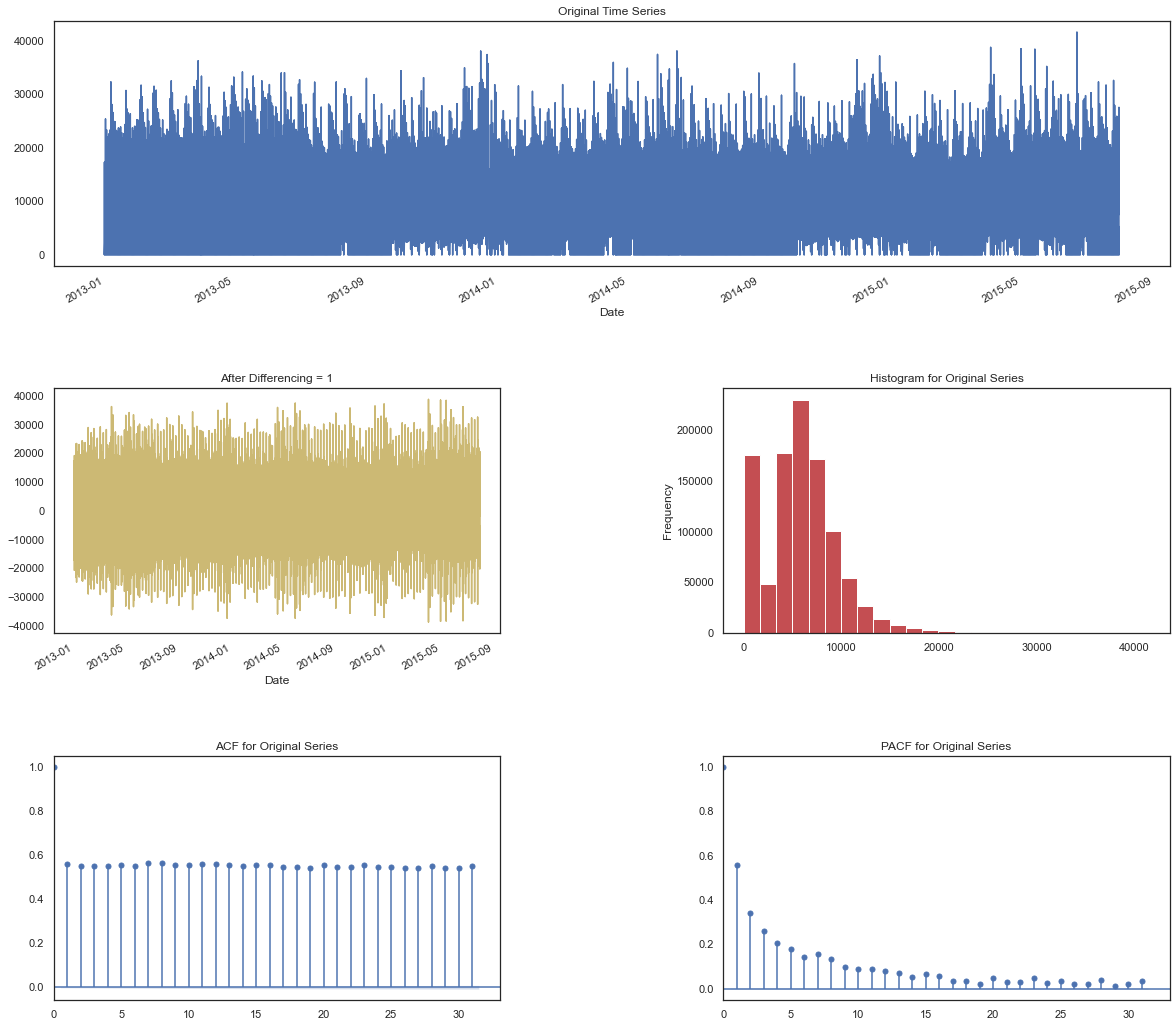

Time Interval is given as D
    Correct Time interval given as a valid Pandas date-range frequency...


Building ML Model



Running Machine Learning Models...
    Shifting 6 predictors by lag=10 to align prior predictor with current target...

Fitting ML model
    39 variables used in training ML model = ['Store(t)', 'DayOfWeek(t)', 'ShopOpen(t)', 'Promotion(t)', 'SchoolHoliday(t)', 'Store(t-4)', 'DayOfWeek(t-4)', 'ShopOpen(t-4)', 'Promotion(t-4)', 'SchoolHoliday(t-4)', 'Sales(t-4)', 'Store(t-3)', 'DayOfWeek(t-3)', 'ShopOpen(t-3)', 'Promotion(t-3)', 'SchoolHoliday(t-3)', 'Sales(t-3)', 'Store(t-2)', 'DayOfWeek(t-2)', 'ShopOpen(t-2)', 'Promotion(t-2)', 'SchoolHoliday(t-2)', 'Sales(t-2)', 'Store(t-1)', 'DayOfWeek(t-1)', 'ShopOpen(t-1)', 'Promotion(t-1)', 'SchoolHoliday(t-1)', 'Sales(t-1)', 'Date_hour', 'Date_minute', 'Date_dayofweek', 'Date_quarter', 'Date_month', 'Date_year', 'Date_dayofyear', 'Date_dayofmonth', 'Date_weekofyear', 'Date_weekend']

Running Cross Validation using XGBoost 

KeyboardInterrupt: 

In [39]:
model.fit(train, ts_column,target)

In [ ]:
predictions = model.predict(
            testdata=testx,
            model='ML',
        )

In [ ]:
pred_x = predictions['yhat'].values
pred_x

In [ ]:
out_df = pd.DataFrame({'id': test['id'].astype(np.int32), 'sales': pred_x})
out_df.to_csv('submission.csv', index=False)